In [4]:
# Cell 0 — Reload one sample .svc file and preprocess it
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

DATA_ROOT = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\PaHaW_dataset")

# pick sample file
files = list((DATA_ROOT / "PaHaW_public").rglob("*.svc"))
sample_file = files[0]
print("Using sample file:", sample_file)

# load file
def load_svc(path):
    with open(path, 'r') as f:
        lines = f.read().strip().splitlines()
    n = int(lines[0].strip())
    rows = []
    for ln in lines[1:]:
        parts = ln.split()
        if len(parts) != 7: 
            continue
        x, y, ts, pen, az, alt, pr = parts
        rows.append([float(x), float(y), float(ts), float(pen), 
                     float(az), float(alt), float(pr)])
    df = pd.DataFrame(rows, columns=["x", "y", "time", "pen", "azim", "alt", "press"])
    return df

df = load_svc(sample_file)
print("Loaded shape:", df.shape)

# --- Preprocessing (same as notebook 2) ---
df['y'] = df['y'] - df['y'].mean()
df['time_s'] = df['time'] - df['time'].iloc[0]

df['dt'] = df['time_s'].diff().fillna(0)
df.loc[df['dt'] <= 0, 'dt'] = 1/1000

df['x_s'] = df['x'].rolling(3, center=True, min_periods=1).mean()
df['y_s'] = df['y'].rolling(3, center=True, min_periods=1).mean()

df['vx'] = df['x_s'].diff() / df['dt']
df['vy'] = df['y_s'].diff() / df['dt']
df['vx'] = df['vx'].fillna(0)
df['vy'] = df['vy'].fillna(0)

df['speed'] = np.sqrt(df['vx']**2 + df['vy']**2)

df['ax'] = df['vx'].diff() / df['dt']
df['ay'] = df['vy'].diff() / df['dt']
df['ax'] = df['ax'].fillna(0)
df['ay'] = df['ay'].fillna(0)

df['accel'] = np.sqrt(df['ax']**2 + df['ay']**2)
df['jerk'] = df['accel'].diff().fillna(0) / df['dt']

df_proc = df.copy()

# --- Detect pen strokes (same as notebook 2) ---
pen_mask = df_proc['pen'] == 1
pen_strokes = []
start = None
for i, on in enumerate(pen_mask):
    if on and start is None:
        start = i
    elif not on and start is not None:
        pen_strokes.append((start, i-1))
        start = None
if start is not None:
    pen_strokes.append((start, len(df_proc)-1))

print("pen_strokes:", pen_strokes)
print("df_proc ready.")


Using sample file: C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\PaHaW_dataset\PaHaW_public\00001\00001__1_1.svc
Loaded shape: (1772, 7)
pen_strokes: [(0, 1771)]
df_proc ready.


Total pen_strokes: 1   -> sub-strokes: 176
First 12 sub-strokes (start,end): [(0, 8), (9, 31), (32, 43), (44, 53), (54, 74), (75, 93), (94, 105), (106, 113), (114, 122), (123, 130), (131, 140), (141, 151)]


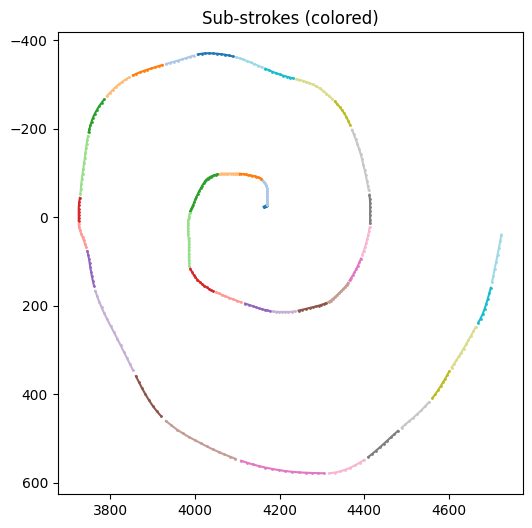

In [5]:
# Cell A — split long pen-strokes into substrokes by local minima in speed and visualize
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import itertools

# reuse df_proc (from preprocessing) — if not present, reload df_sample -> df_proc as before
# We'll split every pen stroke we found previously (pen_strokes)

def split_all_strokes_by_speed(df, pen_strokes, prom=0.05, dist=8, min_points=6):
    all_subs = []
    for idx, (s,e) in enumerate(pen_strokes):
        seg = df.iloc[s:e+1].reset_index(drop=True)
        speed = seg['speed'].to_numpy()
        inv = -speed
        peaks, props = find_peaks(inv, prominence=prom, distance=dist)
        if len(peaks)==0:
            intervals = [(s,e)]
        else:
            cuts = [s + int(p) for p in peaks]
            intervals = []
            prev = s
            for c in cuts:
                intervals.append((prev, c))
                prev = c+1
            if prev <= e:
                intervals.append((prev, e))
        # filter very small intervals
        intervals = [iv for iv in intervals if (iv[1]-iv[0]+1) >= min_points]
        # if all filtered out, keep original
        if len(intervals)==0:
            intervals = [(s,e)]
        all_subs.extend(intervals)
    return all_subs

# run splitting with default params (tune if needed)
subs = split_all_strokes_by_speed(df_proc, pen_strokes, prom=0.05, dist=8, min_points=6)
print("Total pen_strokes:", len(pen_strokes), "  -> sub-strokes:", len(subs))
print("First 12 sub-strokes (start,end):", subs[:12])

# plot first 40 substrokes colored
def plot_strokes(df, strokes, title="Sub-strokes (colored)", max_show=40):
    plt.figure(figsize=(6,6))
    colors = itertools.cycle(plt.cm.tab20.colors)
    for (s,e), c in zip(strokes[:max_show], colors):
        seg = df.iloc[s:e+1]
        plt.plot(seg['x_s'], seg['y_s'], '-', marker='.', markersize=2, color=c)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()

plot_strokes(df_proc, subs, "Sub-strokes (colored)")


In [6]:
# Cell B — Beta velocity model fitting per sub-stroke
import numpy as np
from scipy.optimize import curve_fit
import math

def beta_velocity(t, A, t0, t1, a, b):
    """
    Beta-shaped velocity:
      u = (t - t0) / (t1 - t0)
      v = A * u^a * (1 - u)^b  for u in (0,1), else 0
    """
    t = np.array(t)
    v = np.zeros_like(t, dtype=float)
    denom = (t1 - t0) if (t1 - t0) != 0 else 1e-8
    u = (t - t0) / denom
    # mask inside
    mask = (u > 0) & (u < 1)
    uu = u[mask]
    # avoid zero exponents causing NaNs
    with np.errstate(all='ignore'):
        v_mask = A * (uu**a) * ((1 - uu)**b)
    v[mask] = v_mask
    return v

def fit_beta_to_substroke(df, s, e, min_points=8):
    seg = df.iloc[s:e+1].reset_index(drop=True)
    if len(seg) < min_points:
        return None  # too short to fit
    t = seg['time_s'].to_numpy()
    speed = seg['speed'].to_numpy()
    # initial guesses
    A0 = np.max(speed) if np.max(speed)>0 else 1.0
    t0_0 = t[0]
    t1_0 = t[-1]
    a0 = 2.0
    b0 = 2.0
    p0 = [A0, t0_0, t1_0, a0, b0]
    bounds = ([0.0, t[0]-0.1, t[-1]-1.0, 0.1, 0.1],
              [A0*10+1.0, t[0]+0.5, t[-1]+0.5, 10.0, 10.0])
    try:
        popt, pcov = curve_fit(beta_velocity, t, speed, p0=p0, bounds=bounds, maxfev=20000)
        return {"A":float(popt[0]), "t0":float(popt[1]), "t1":float(popt[2]), "a":float(popt[3]), "b":float(popt[4])}
    except Exception as ex:
        # fitting failed
        return None

# Fit over all substrokes and collect results
beta_results = []
for idx, (s,e) in enumerate(subs):
    res = fit_beta_to_substroke(df_proc, s, e, min_points=8)
    beta_results.append({"sub_id": idx, "start": s, "end": e, "n_points": e-s+1, "beta": res})

beta_df = pd.DataFrame(beta_results)
print("Beta fit attempts:", len(beta_df), " successful fits:", beta_df['beta'].notnull().sum())
display(beta_df.head(12))


Beta fit attempts: 176  successful fits: 176


,sub_id,start,end,n_points,beta
0,0,0,8,9,"{'A': 0.45546074676128684, 't0': 0.49999999999..."
1,1,9,31,23,"{'A': 0.809963140150684, 't0': 67.499999999999..."
2,2,32,43,12,"{'A': 0.8298528784753406, 't0': 239.9000000000..."
3,3,44,53,10,"{'A': 0.8925359033501874, 't0': 329.9000000000..."
4,4,54,74,21,"{'A': 1.0685985941632399, 't0': 404.9000000000..."
5,5,75,93,19,"{'A': 1.1131331222505965, 't0': 562.9000000000..."
6,6,94,105,12,"{'A': 1.1808897491992003, 't0': 705.9000000000..."
7,7,106,113,8,"{'A': 1.4763502933468409, 't0': 795.9000000000..."
8,8,114,122,9,"{'A': 1.4246998832961684, 't0': 855.9000000000..."
9,9,123,130,8,"{'A': 1.2241305582760826, 't0': 923.9000000000..."


In [7]:
# Cell C — ellipse fit using Direct Least Squares (Fitzgibbon) and parameter conversion
import numpy as np

def fit_ellipse(xs, ys):
    # Direct least squares fitting of ellipses (Fitzgibbon 1999)
    x = xs[:,None]; y = ys[:,None]
    D = np.hstack([x*x, x*y, y*y, x, y, np.ones_like(x)])
    S = np.dot(D.T, D)
    # constraint matrix
    C = np.zeros((6,6))
    C[0,2] = C[2,0] = 2
    C[1,1] = -1
    # solve generalized eigenvalue problem
    try:
        import scipy.linalg as la
        eigvals, eigvecs = la.eig(S, C)
        eigvals = np.real(eigvals)
        eigvecs = np.real(eigvecs)
        # pick eigenvector with positive eigenvalue and valid (avoid tiny)
        pos = np.where(np.isfinite(eigvals))[0]
        # choose the eigenvector corresponding to the smallest positive eigenvalue
        idx = pos[np.argmin(eigvals[pos])]
        a = eigvecs[:, idx]
        # algebraic coefficients
        A, B, Cc, Dd, E, Ff = a.flatten()
    except Exception as e:
        # fallback: use np.linalg.lstsq to approximate (less constrained)
        try:
            a, *_ = np.linalg.lstsq(D, np.zeros((D.shape[0],)), rcond=None)
            A, B, Cc, Dd, E, Ff = a.flatten()
        except Exception:
            return None

    # convert algebraic to geometric ellipse parameters
    # center
    denom = B*B - 4*A*Cc
    if denom == 0:
        return None
    x0 = (2*Cc*Dd - B*E) / denom
    y0 = (2*A*E - B*Dd) / denom
    # axes and angle
    up = 2*(A*E*E + Cc*Dd*Dd + Ff*B*B - 2*B*Dd*E - A*Cc*Ff)
    down1 = (B*B - 4*A*Cc) * ( (Cc - A) + np.sqrt((A-Cc)*(A-Cc) + B*B) )
    down2 = (B*B - 4*A*Cc) * ( (Cc - A) - np.sqrt((A-Cc)*(A-Cc) + B*B) )
    if down1 == 0 or down2 == 0:
        return None
    a_len = np.sqrt( up / down1 )
    b_len = np.sqrt( up / down2 )
    theta = 0.5 * np.arctan2(B, (A - Cc))
    # ensure a_len >= b_len
    if b_len > a_len:
        a_len, b_len = b_len, a_len
    eccentricity = np.sqrt(max(0, 1 - (b_len**2)/(a_len**2)))
    return {"xc":float(x0), "yc":float(y0), "a":float(a_len), "b":float(b_len), "angle_rad":float(theta), "ecc":float(eccentricity)}

# Fit ellipse on substrokes
ellipse_results = []
for idx, (s,e) in enumerate(subs):
    seg = df_proc.iloc[s:e+1]
    xs = seg['x_s'].to_numpy()
    ys = seg['y_s'].to_numpy()
    if len(xs) < 5:
        ellipse_results.append({"sub_id": idx, "ellipse": None})
        continue
    res = fit_ellipse(xs, ys)
    ellipse_results.append({"sub_id": idx, "start": s, "end": e, "n_points": len(xs), "ellipse": res})

ellipse_df = pd.DataFrame(ellipse_results)
print("Ellipse fits attempted:", len(ellipse_df), " successful:", ellipse_df['ellipse'].notnull().sum())
display(ellipse_df.head(12))


Ellipse fits attempted: 176  successful: 168


C:\Users\aibel\AppData\Local\Temp\ipykernel_20724\2833956676.py:47: RuntimeWarning: invalid value encountered in sqrt
  a_len = np.sqrt( up / down1 )
C:\Users\aibel\AppData\Local\Temp\ipykernel_20724\2833956676.py:48: RuntimeWarning: invalid value encountered in sqrt
  b_len = np.sqrt( up / down2 )


,sub_id,start,end,n_points,ellipse
0,0,0,8,9,"{'xc': 2083.588512327638, 'yc': -14.9097526102..."
1,1,9,31,23,"{'xc': 4166.763479231354, 'yc': -55.6745831704..."
2,2,32,43,12,"{'xc': 2068.4835930239747, 'yc': -41.428660770..."
3,3,44,53,10,"{'xc': 4056.202814178768, 'yc': -98.0196536529..."
4,4,54,74,21,"{'xc': 4001.436020735016, 'yc': -117.747384150..."
5,5,75,93,19,"{'xc': 3653.2712529597884, 'yc': 45.0913760975..."
6,6,94,105,12,"{'xc': 3891.078049601283, 'yc': 91.75719012325..."
7,7,106,113,8,"{'xc': 4077.105024296492, 'yc': 248.2189827411..."
8,8,114,122,9,"{'xc': 4138.027701316261, 'yc': 222.8500816898..."
9,9,123,130,8,"{'xc': 4246.747456122612, 'yc': 216.9342150637..."


In [8]:
import pickle
import os

SAVE_DIR = r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save df_proc
df_proc.to_pickle(os.path.join(SAVE_DIR, "df_proc.pkl"))

# Save subs
with open(os.path.join(SAVE_DIR, "subs.pkl"), "wb") as f:
    pickle.dump(subs, f)

# Save beta_df
beta_df.to_pickle(os.path.join(SAVE_DIR, "beta_df.pkl"))

# Save ellipse_df
ellipse_df.to_pickle(os.path.join(SAVE_DIR, "ellipse_df.pkl"))

print("All processed data saved successfully!")


All processed data saved successfully!
